# Finance Libraries

In [1]:
import numpy as np
import pandas as pd

# Yahoo Finance

In [2]:
import yfinance as yf

msft = yf.Ticker("MSFT")

print(yf.__version__)

#msft.info # not working due to decryption issue

0.2.13b1


# Yahooquery

In [3]:
from yahooquery import Ticker

aapl = Ticker('aapl')

aapl.summary_detail

{'aapl': {'maxAge': 1,
  'priceHint': 2,
  'previousClose': 158.93,
  'open': 158.86,
  'dayLow': 157.85,
  'dayHigh': 160.34,
  'regularMarketPreviousClose': 158.93,
  'regularMarketOpen': 158.86,
  'regularMarketDayLow': 157.85,
  'regularMarketDayHigh': 160.34,
  'dividendRate': 0.92,
  'dividendYield': 0.0058,
  'exDividendDate': '2023-02-10 08:00:00',
  'payoutRatio': 0.1545,
  'fiveYearAvgDividendYield': 0.95,
  'beta': 1.297088,
  'trailingPE': 26.752922,
  'forwardPE': 24.24357,
  'volume': 59256343,
  'regularMarketVolume': 59256343,
  'averageVolume': 70658500,
  'averageVolume10days': 76044460,
  'averageDailyVolume10Day': 76044460,
  'bid': 160.2,
  'ask': 160.03,
  'bidSize': 800,
  'askSize': 800,
  'marketCap': 2535459389440,
  'fiftyTwoWeekLow': 124.17,
  'fiftyTwoWeekHigh': 179.61,
  'priceToSalesTrailing12Months': 6.542496,
  'fiftyDayAverage': 148.8754,
  'twoHundredDayAverage': 147.9403,
  'trailingAnnualDividendRate': 0.91,
  'trailingAnnualDividendYield': 0.005725

# ta-lib-python

In [4]:
import talib
from yahooquery import Ticker

In [5]:
ticker = Ticker("aapl")
close = ticker.history()["close"]
print(close)

symbol  date      
aapl    2023-01-03    125.070000
        2023-01-04    126.360001
        2023-01-05    125.019997
        2023-01-06    129.619995
        2023-01-09    130.149994
        2023-01-10    130.729996
        2023-01-11    133.490005
        2023-01-12    133.410004
        2023-01-13    134.759995
        2023-01-17    135.940002
        2023-01-18    135.210007
        2023-01-19    135.270004
        2023-01-20    137.869995
        2023-01-23    141.110001
        2023-01-24    142.529999
        2023-01-25    141.860001
        2023-01-26    143.960007
        2023-01-27    145.929993
        2023-01-30    143.000000
        2023-01-31    144.289993
        2023-02-01    145.429993
        2023-02-02    150.820007
        2023-02-03    154.500000
        2023-02-06    151.729996
        2023-02-07    154.649994
        2023-02-08    151.919998
        2023-02-09    150.869995
        2023-02-10    151.009995
        2023-02-13    153.850006
        2023-02-14    15

<AxesSubplot:xlabel='symbol,date'>

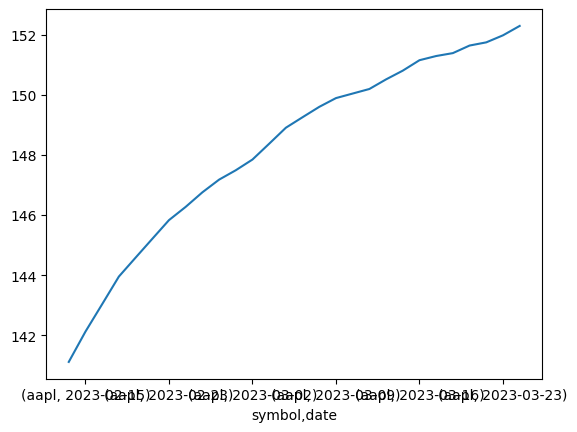

In [6]:
output = talib.SMA(close)
output.plot()

# Backtesting.py

In [7]:
import warnings
warnings.filterwarnings("ignore")

import backtesting
from yahooquery import Ticker

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA

ticker = Ticker("aapl")
AAPL = ticker.history("2y")
AAPL = AAPL.rename({'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, axis=1)
AAPL.reset_index(level="symbol", inplace=True)

class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(AAPL, SmaCross, commission=.002, exclusive_orders=True)
stats = bt.run()
bt.plot()

Loading BokehJS ...

GridPlot(id='p1480', ...)

# QuantStats

In [8]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('GOOG')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas() :)
stock.sharpe()

0.8067807131816986

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


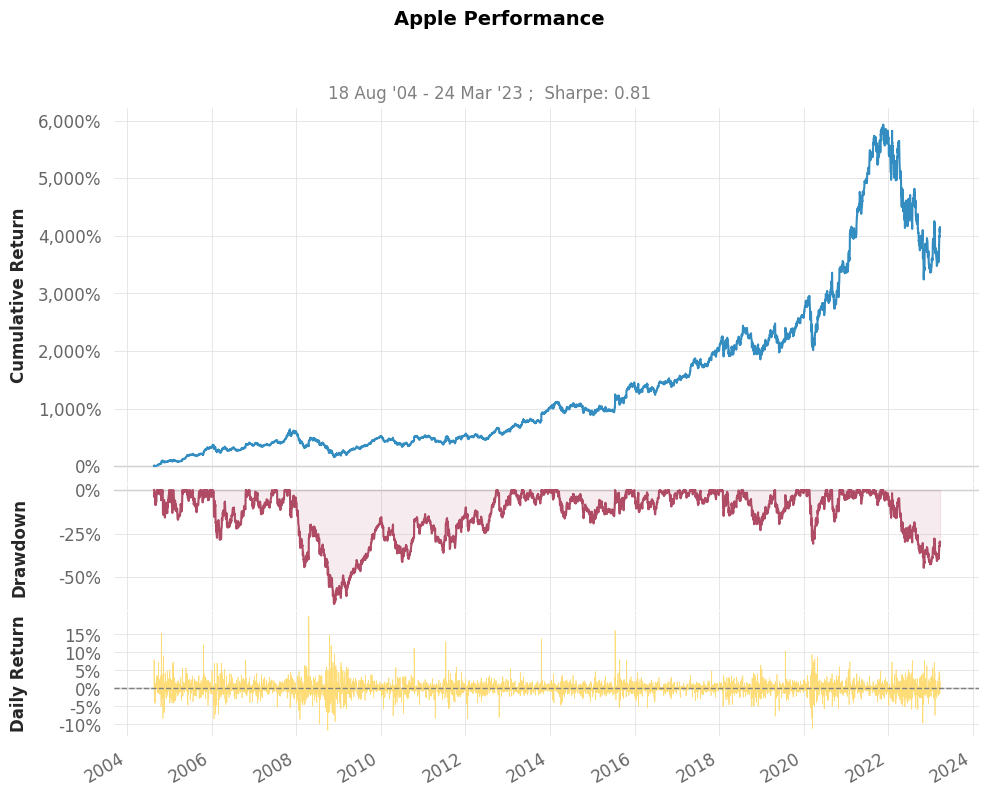

In [9]:
qs.plots.snapshot(stock, title='Apple Performance')

# can also be called via:
# stock.plot_snapshot(title='Facebook Performance')

In [10]:
#qs.reports.html(stock, "SPY")

# Basana

In [11]:
from decimal import Decimal
import asyncio
import logging

from talipp.indicators import SMA

from basana.external.binance import csv
import basana as bs
import basana.backtesting.exchange as backtesting_exchange


# The strategy implements the set of rules that define when to enter or exit a trade based on market conditions.
class SMA_Strategy(bs.TradingSignalSource):
    def __init__(self, dispatcher: bs.EventDispatcher, period: int):
        super().__init__(dispatcher)
        self._sma = SMA(period)
        self._values = (None, None)

    async def on_bar_event(self, bar_event: bs.BarEvent):
        # Feed the technical indicator.
        value = float(bar_event.bar.close)
        self._sma.add_input_value(value)

        # Keep a small window of values to check if there is a crossover.
        self._values = (self._values[-1], value)

        # Is the indicator ready ?
        if len(self._sma) < 2:
            return

        # Price crossed below SMA ?
        if self._values[-2] >= self._sma[-2] and self._values[-1] < self._sma[-1]:
            self.push(bs.TradingSignal(bar_event.when, bs.OrderOperation.SELL, bar_event.bar.pair))
        # Price crossed above SMA ?
        elif self._values[-2] <= self._sma[-2] and self._values[-1] > self._sma[-1]:
            self.push(bs.TradingSignal(bar_event.when, bs.OrderOperation.BUY, bar_event.bar.pair))


# The position manager is responsible for executing trades and managing positions.
class PositionManager:
    def __init__(self, exchange: backtesting_exchange.Exchange, position_amount: Decimal):
        assert position_amount > 0
        self._exchange = exchange
        self._position_amount = position_amount

    async def on_trading_signal(self, trading_signal: bs.TradingSignal):
        logging.info("Trading signal: operation=%s pair=%s", trading_signal.operation, trading_signal.pair)
        try:
            # Calculate the order size.
            balances = await self._exchange.get_balances()
            if trading_signal.operation == bs.OrderOperation.BUY:
                _, ask = await self._exchange.get_bid_ask(trading_signal.pair)
                balance = balances[trading_signal.pair.quote_symbol]
                order_size = min(self._position_amount, balance.available) / ask
            else:
                balance = balances[trading_signal.pair.base_symbol]
                order_size = balance.available
            pair_info = await self._exchange.get_pair_info(trading_signal.pair)
            order_size = bs.truncate_decimal(order_size, pair_info.base_precision)
            if not order_size:
                return

            logging.info(
                "Creating %s market order for %s: amount=%s", trading_signal.operation, trading_signal.pair, order_size
            )
            await self._exchange.create_market_order(trading_signal.operation, trading_signal.pair, order_size)
        except Exception as e:
            logging.error(e)


async def main():
    logging.basicConfig(level=logging.INFO, format="[%(asctime)s %(levelname)s] %(message)s")

    event_dispatcher = bs.backtesting_dispatcher()
    pair = bs.Pair("BTC", "USDT")
    exchange = backtesting_exchange.Exchange(
        event_dispatcher,
        initial_balances={"BTC": Decimal(0), "USDT": Decimal(10000)}
    )
    exchange.set_pair_info(pair, bs.PairInfo(8, 2))

    # Connect the strategy to the bar events from the exchange.
    strategy = SMA_Strategy(event_dispatcher, 15)
    exchange.subscribe_to_bar_events(pair, strategy.on_bar_event)

    # Connect the position manager to the strategy signals.
    position_mgr = PositionManager(exchange, Decimal(1000))
    strategy.subscribe_to_trading_signals(position_mgr.on_trading_signal)

    # Load bars from CSV files.
    exchange.add_bar_source(csv.BarSource(pair, "data/binance_btcusdt_day.csv", "1d"))

    # Run the backtest.
    await event_dispatcher.run()

    # Log balances.
    balances = await exchange.get_balances()
    for currency, balance in balances.items():
        logging.info("%s balance: %s", currency, balance.available)



await main()

[2017-09-05 07:59:59,999 INFO] Trading signal: operation=sell pair=BTC/USDT
[2017-09-07 07:59:59,999 INFO] Trading signal: operation=buy pair=BTC/USDT
[2017-09-07 07:59:59,999 INFO] Creating buy market order for BTC/USDT: amount=0.21592162
[2017-09-09 07:59:59,999 INFO] Trading signal: operation=sell pair=BTC/USDT
[2017-09-09 07:59:59,999 INFO] Creating sell market order for BTC/USDT: amount=0.21592162
[2017-09-26 07:59:59,999 INFO] Trading signal: operation=buy pair=BTC/USDT
[2017-09-26 07:59:59,999 INFO] Creating buy market order for BTC/USDT: amount=0.25441732
[2017-10-25 07:59:59,999 INFO] Trading signal: operation=sell pair=BTC/USDT
[2017-10-25 07:59:59,999 INFO] Creating sell market order for BTC/USDT: amount=0.25441732
[2017-10-26 07:59:59,999 INFO] Trading signal: operation=buy pair=BTC/USDT
[2017-10-26 07:59:59,999 INFO] Creating buy market order for BTC/USDT: amount=0.17530911
[2017-10-29 07:59:59,999 INFO] Trading signal: operation=sell pair=BTC/USDT
[2017-10-29 07:59:59,999

# Blankly

In [12]:
from blankly import Alpaca, CoinbasePro

#stocks = Alpaca()
#crypto = CoinbasePro()
#futures = BinanceFutures()

# Easily perform the same actions across exchanges & asset types
#stocks.interface.market_order('AAPL', 'buy', 1)
#crypto.interface.market_order('BTC-USD', 'buy', 1)
# Full futures feature set
#futures.interface.get_hedge_mode()

# PyPortfolioOpt

In [13]:
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
from yahooquery import Ticker

symbols = ['GOOGL', 'TSLA', 'AMZN', 'AAPL', 'MSFT']

tickers = Ticker(symbols)

hist_prices = tickers.history(period="5y").reset_index()
hist_prices.head(10)

symbol        date       open       high        low      close    volume  \
0  GOOGL  2018-03-26  52.529999  52.963501  50.528999  52.704498  65984000   
1  GOOGL  2018-03-27  53.195000  53.227001  49.881001  50.347000  60816000   
2  GOOGL  2018-03-28  50.095501  51.249500  49.200001  50.258999  77698000   
3  GOOGL  2018-03-29  50.560501  52.402500  50.202000  51.856998  69338000   
4  GOOGL  2018-04-02  51.381001  51.976501  49.712502  50.631500  65068000   
5  GOOGL  2018-04-03  50.807499  51.250000  49.862499  50.933998  51322000   
6  GOOGL  2018-04-04  49.911499  51.637001  49.825500  51.485500  50724000   
7  GOOGL  2018-04-05  52.319500  52.335499  51.200001  51.632000  35836000   
8  GOOGL  2018-04-06  51.154999  51.799999  50.312500  50.497501  40134000   
9  GOOGL  2018-04-09  51.001999  52.229500  50.959999  51.004501  33220000   

    adjclose  splits  dividends  
0  52.704498     0.0        0.0  
1  50.347000     0.0        0.0  
2  50.258999     0.0        0.0  
3  51.856998     0.0        0.0  
4  50.631500     0.0        0.0  
5  50.933998     0.0        0.0  
6  51.485500     0.0        0.0  
7  51.632000     0.0        0.0  
8  50.497501     0.0        0.0  
9  51.004501     0.0        0.0

In [15]:
close_prices = hist_prices.pivot(index='date', columns='symbol', values='close')
close_prices.head(10)

symbol           AAPL       AMZN      GOOGL       MSFT       TSLA
date                                                             
2018-03-26  43.192501  77.792999  52.704498  93.779999  20.278667
2018-03-27  42.084999  74.852501  50.347000  89.470001  18.612000
2018-03-28  41.619999  71.570999  50.258999  89.389999  17.185333
2018-03-29  41.945000  72.366997  51.856998  91.269997  17.742001
2018-04-02  41.669998  68.599503  50.631500  88.519997  16.832001
2018-04-03  42.097500  69.602501  50.933998  89.709999  17.835333
2018-04-04  42.902500  70.528503  51.485500  92.330002  19.129333
2018-04-05  43.200001  72.587502  51.632000  92.379997  20.381332
2018-04-06  42.095001  70.261497  50.497501  90.230003  19.953333
2018-04-09  42.512501  70.304001  51.004501  90.769997  19.310667

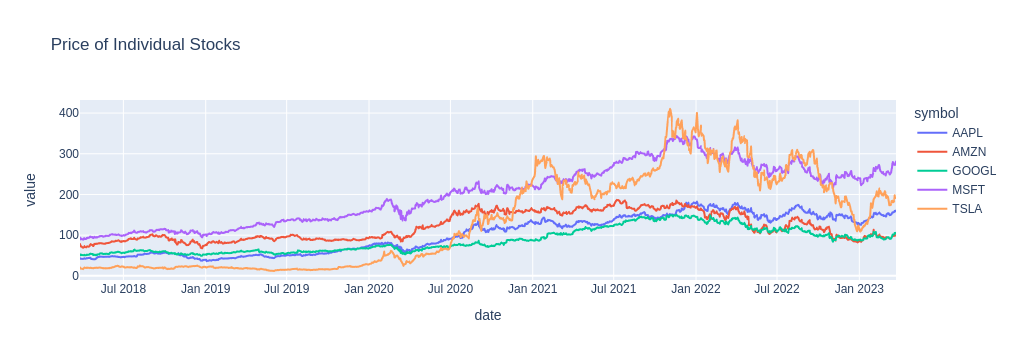

In [16]:
fig_price = px.line(close_prices, title='Price of Individual Stocks')
fig_price.show()

In [17]:
# daily returns
daily_returns = close_prices.pct_change().dropna()
daily_returns.head()

symbol          AAPL      AMZN     GOOGL      MSFT      TSLA
date                                                        
2018-03-27 -0.025641 -0.037799 -0.044730 -0.045959 -0.082188
2018-03-28 -0.011049 -0.043840 -0.001748 -0.000894 -0.076653
2018-03-29  0.007809  0.011122  0.031795  0.021031  0.032392
2018-04-02 -0.006556 -0.052061 -0.023632 -0.030130 -0.051291
2018-04-03  0.010259  0.014621  0.005974  0.013443  0.059609

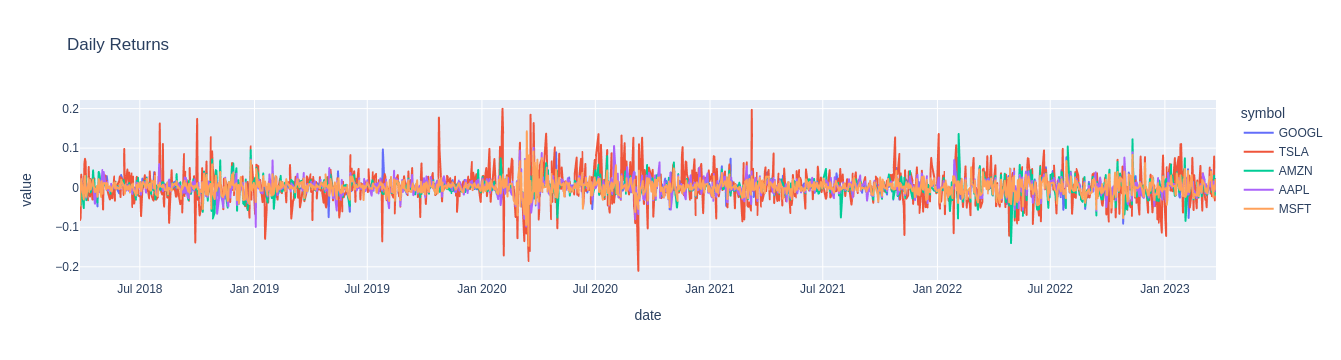

In [18]:
fig = px.line(daily_returns[symbols], title='Daily Returns')
fig.show()

In [19]:
# daily volatility
daily_returns.std()

symbol
AAPL     0.021057
AMZN     0.022842
GOOGL    0.020074
MSFT     0.019559
TSLA     0.042051
dtype: float64

(-0.1, 0.1)

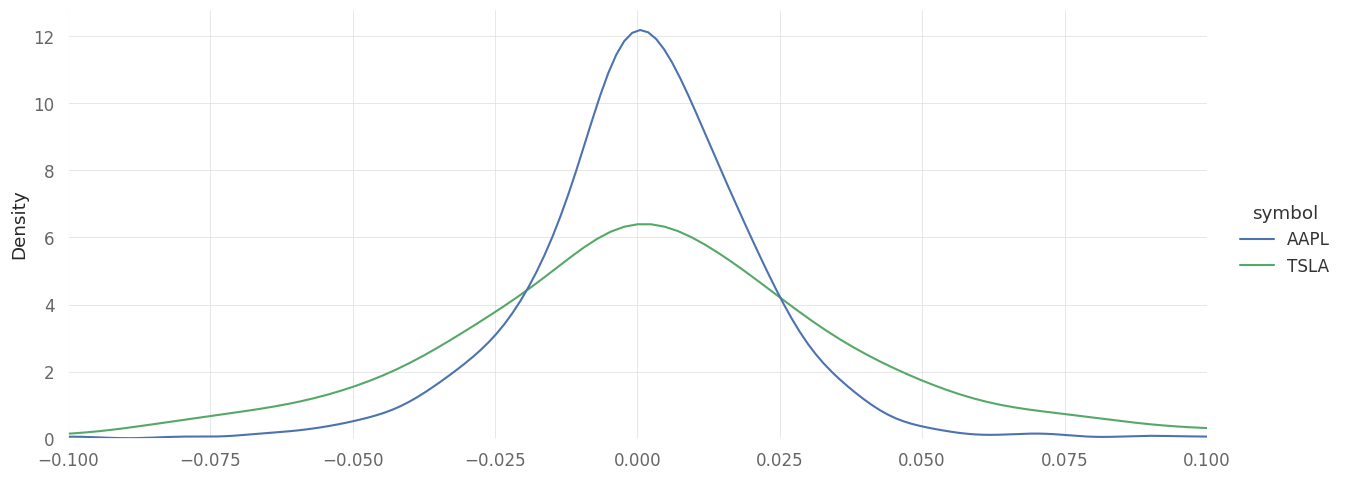

In [20]:
sns.displot(data=daily_returns[['AAPL', 'TSLA']], kind = 'kde', aspect = 2.5)
plt.xlim(-0.1, 0.1)

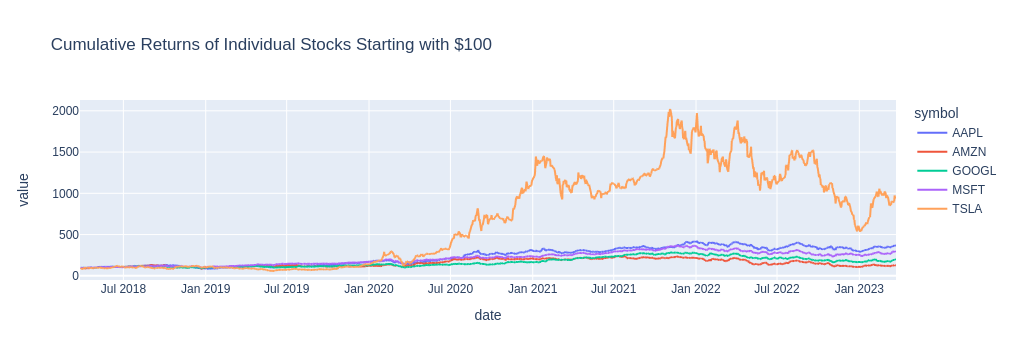

In [21]:
# Cumulative returns
def plot_cum_returns(data, title):    
    daily_cum_returns = 1 + data.dropna().pct_change()
    daily_cum_returns = daily_cum_returns.cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig
    
fig_cum_returns = plot_cum_returns(close_prices, 'Cumulative Returns of Individual Stocks Starting with $100')
fig_cum_returns.show()

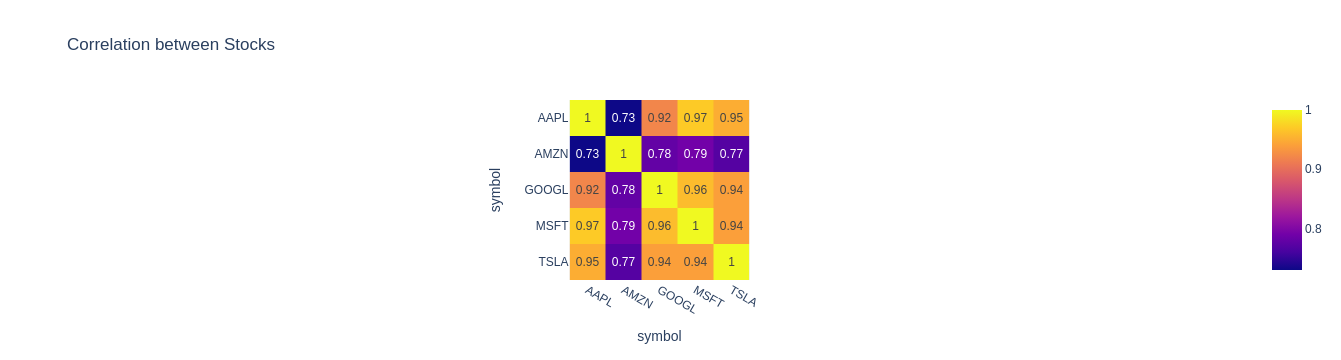

In [22]:
# Correlation matrix
corr_df = close_prices.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Stocks')
fig_corr.show()

In [23]:
# Expected Returns and Covariance Matrix
mu = expected_returns.mean_historical_return(close_prices)
S = risk_models.sample_cov(close_prices)
print(mu)

symbol
AAPL     0.300346
AMZN     0.047621
GOOGL    0.149019
MSFT     0.245482
TSLA     0.566172
dtype: float64


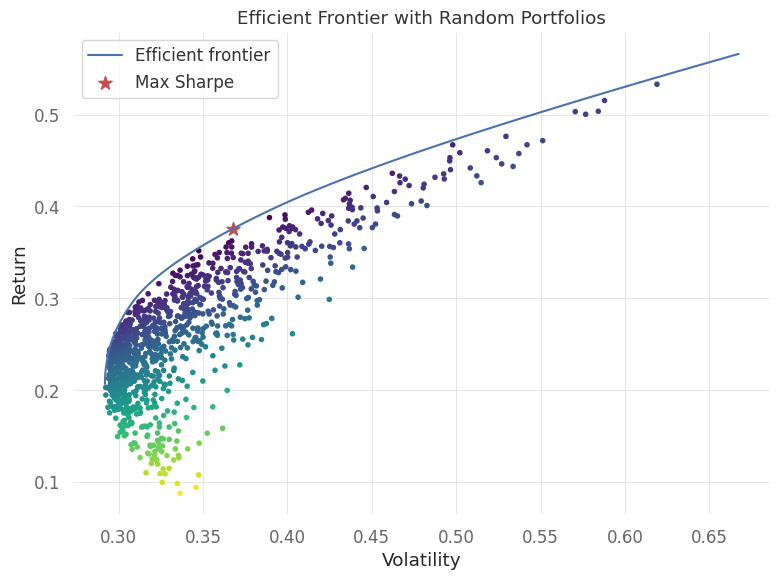

In [24]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r",     label="Max Sharpe")
# Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu, S)

In [25]:
# Weights for Optimized Portfolio
ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.02)
weights = ef.clean_weights()
print(weights)

OrderedDict([('AAPL', 0.5988), ('AMZN', 0.0), ('GOOGL', 0.0), ('MSFT', 0.09717), ('TSLA', 0.30403)])


In [26]:
weights_df = pd.DataFrame.from_dict(weights, orient = 'index')
weights_df.columns = ['weights']
weights_df

weights
AAPL   0.59880
AMZN   0.00000
GOOGL  0.00000
MSFT   0.09717
TSLA   0.30403

In [27]:
# Expected Annual Return, Annual Volatility and Sharpe Ratio for Optimized Portfolio
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()
print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

Expected annual return: 37.58%
Annual volatility: 36.77%
Sharpe ratio: 0.97


In [28]:
# Portfolio with Optimized Weights
close_prices['Optimized Portfolio'] = 0
for ticker, weight in weights.items():
    close_prices['Optimized Portfolio'] += close_prices[ticker]*weight
close_prices.head()

symbol           AAPL       AMZN      GOOGL       MSFT       TSLA  \
date                                                                
2018-03-26  43.192501  77.792999  52.704498  93.779999  20.278667   
2018-03-27  42.084999  74.852501  50.347000  89.470001  18.612000   
2018-03-28  41.619999  71.570999  50.258999  89.389999  17.185333   
2018-03-29  41.945000  72.366997  51.856998  91.269997  17.742001   
2018-04-02  41.669998  68.599503  50.631500  88.519997  16.832001   

symbol      Optimized Portfolio  
date                             
2018-03-26            41.141595  
2018-03-27            39.552904  
2018-03-28            38.832938  
2018-03-29            39.379472  
2018-04-02            38.670916

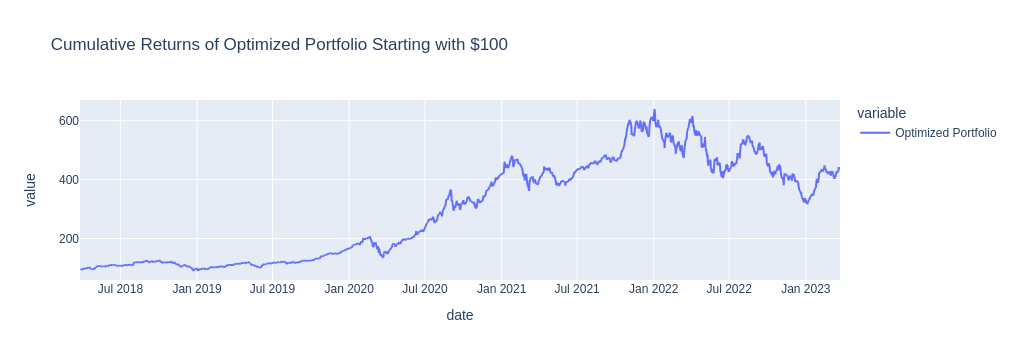

In [29]:
fig_cum_returns_optimized = plot_cum_returns(close_prices['Optimized Portfolio'], 'Cumulative Returns of Optimized Portfolio Starting with $100')
fig_cum_returns_optimized.show()

# Lux

In [36]:
# https://lux-api.readthedocs.io/en/latest/source/getting_started/overview.html

In [2]:
from yahooquery import Ticker
import pandas as pd
# import lux

symbols = ['GOOGL', 'TSLA', 'AMZN', 'AAPL', 'MSFT']

tickers = Ticker(symbols)

hist_prices = tickers.history(period="5y").reset_index()
hist_prices = hist_prices.pivot(index='date', columns='symbol', values='close')
hist_prices

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

#### Other libraries
- https://github.com/Qix-/better-exceptions
- https://huey.readthedocs.io/en/latest/
- https://github.com/ray-project/ray
- https://requests.readthedocs.io/projects/requests-html/en/latest/
- https://github.com/pudo/dataset

# pandas-datareader

In [30]:
import pandas_datareader as pdr
# pdr.get_data_yahoo("AAPL") -- not working any more

# finmarketpy

In [31]:
# https://github.com/cuemacro/finmarketpy

# financepy

In [32]:
# https://github.com/domokane/FinancePy/


## ffn

In [33]:
#!pip install ffn

import ffn

# Load portfolio data from a CSV file
# data = ffn.get('AAPL,GOOG,MSFT', start='2018-01-01', end='2022-03-19')

# Not working due to yfinance
